This notebook contains code to extract features from the audio signals.

In [1]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import sklearn
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
data_dir = 'data/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

In [3]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path,'rb'))


In [4]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

In [5]:
zcrs = librosa.feature.zero_crossing_rate(y)
print(zcrs.shape)



(1, 377)


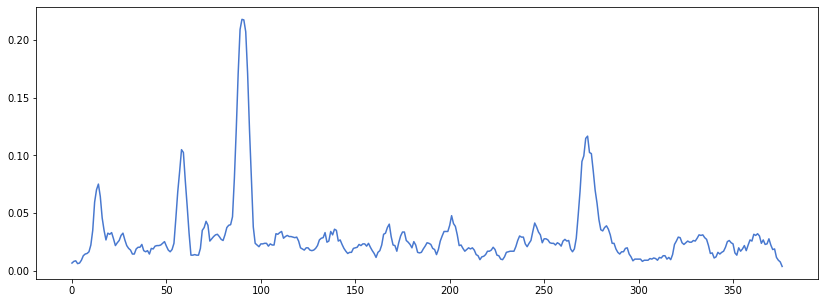

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])


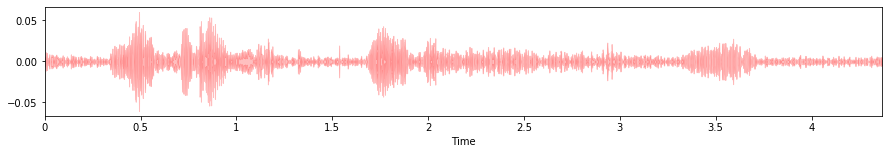

In [ ]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

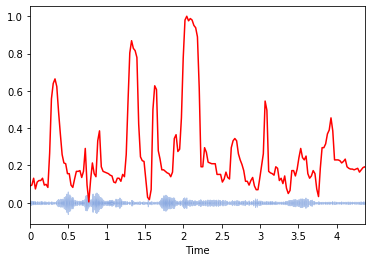

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)

plt.plot(t, normalize(spectral_rolloff), color='r')


In [ ]:
np.mean(spectral_rolloff*.0001)

0.1809474469496021

In [ ]:
np.std(spectral_rolloff*.0001)

0.1068406847645228

In [ ]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.00495
Signal std dev = 0.00771


RMSE mean = 0.00617
RMSE std dev = 0.00461


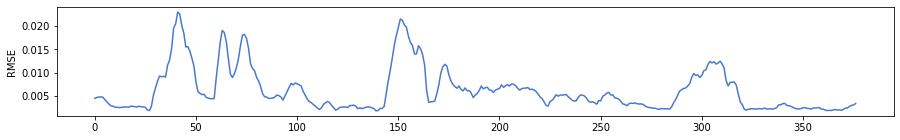

In [ ]:
rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [ ]:
from IPython.display import Audio
Audio(y, rate=44100)

In [ ]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.1830238726790451


In [ ]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-6.164681e-06

In [ ]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print(mfccs.shape)

(20, 377)


In [ ]:
np.std(mfccs)

125.71856186109001

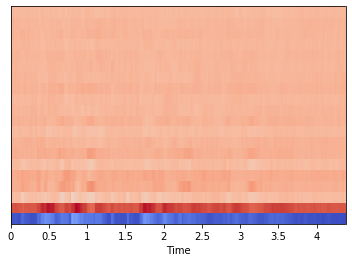

In [ ]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# Features : Pitch 

In [ ]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

11.4403515

In [ ]:
np.mean(abs(y))

0.0049472316

In [ ]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

8.019875886320062

In [ ]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_std', 'silence', 'zcr_std', 'mfcc_mean', 'mfcc_std', 'spec_rff_mean', 'spec_rff_std', 'harmonic', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)
df_features

,wav_file,label,sig_mean,sig_std,rmse_std,silence,zcr_std,mfcc_mean,mfcc_std,spec_rff_mean,spec_rff_std,harmonic,auto_corr_std


The following blocks build feature vectors for all the files

In [ ]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)


In [ ]:
labels_df = pd.read_csv(labels_path)

for sess in [1]:
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rmse = librosa.feature.rmse(y + 0.0001)[0]
                feature_list.append(np.std(rmse))  # rmse_std              
                
                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence
                
                zcr = librosa.feature.zero_crossing_rate(y) #zcr
                feature_list.append(np.std(zcr))
                
                mfccs = librosa.feature.mfcc(y, sr=sr)  #mfccs
                feature_list.append(np.mean(mfccs*.001))
                feature_list.append(np.std(mfccs*.001))
                
                spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)   #spectral_rolloff
                feature_list.append(np.mean(spectral_rolloff*.0001))
                feature_list.append(np.std(spectral_rolloff*.0001))
                
                
                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

df_features.to_csv('data/pre-processed/audio_features1.csv', index=False)

29it [10:10, 11.25s/it]